# Data Cleaning
Convert data to a format that the library likes.

In [1]:
import os

import manga109api
import json

In [2]:
manga109_root = "../datasets/Manga109/Manga109_released_2021_12_30"
dataset = manga109api.Parser(manga109_root)

In [3]:
# import shutil
# import base64
# import numpy as np
#
# os.mkdir("../datasets/Manga109/labelme")
# os.mkdir("../datasets/Manga109/labelme/train")
# os.mkdir("../datasets/Manga109/labelme/test")
# labelme_root = "../datasets/Manga109/labelme/"
# for book in dataset.books:
#     for page in dataset.get_annotation(book)["page"]:
#         # train test split (test size = 0.2)
#         if np.random.uniform() > 0.2:
#             path = labelme_root + "train/"
#         else:
#             path = labelme_root + "test/"
#
#         image_path = path + book + str(page["@index"]).zfill(3) + ".jpg"
#         shutil.copyfile(manga109_root + "/images/" + book + "/" + str(page["@index"]).zfill(3) + ".jpg", image_path) # wasting space
#         encoded = base64.b64encode(open(image_path, "rb").read()) # converting the image into a string for fun
#         result = {"imagePath": book + str(page["@index"]).zfill(3) + ".jpg", "imageHeight": page["@height"],
#                   "imageWidth": page["@width"], "imageData": str(encoded)[2:-2]}
#
#         #adding shape labels
#         shapes = []
#         for frame in page["frame"]:
#             shapes.append({"label": "frame", "shape_type": "rectangle", "points": [[frame["@xmin"], frame["@ymin"]], [frame["@xmin"], frame["@ymax"]], [frame["@xmax"], frame["@ymin"]], [frame["@xmax"], frame["@ymax"]]]})
#         for text in page["text"]:
#             shapes.append({"label": "text", "shape_type": "rectangle", "points": [[text["@xmin"], text["@ymin"]], [text["@xmin"], text["@ymax"]], [text["@xmax"], text["@ymin"]], [text["@xmax"], text["@ymax"]]]})
#         result["shapes"] = shapes
#
#         # write json
#         file = open(path + book + str(page["@index"]).zfill(3) + ".json", "w")
#         json.dump(result, file)
#         file.close()

# Training Segmentation Model

In [4]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import matplotlib.pyplot as plt
import cv2
import manga109api
import numpy as np
import os

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = "model"

# Local path to trained weights file
COCO_MODEL_PATH = "mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configuration

In [5]:
class MangaConfig(Config):
    """Configuration for training on the manga109 dataset.
    Derives from the base Config class and overrides values specific
    to the manga109 dataset.
    """
    # Give the configuration a recognizable name
    NAME = "manga"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 classes (frame + text)

    # Same as COCO dataset
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # Same as COCO dataset
    TRAIN_ROIS_PER_IMAGE = 128

    # Same as COCO dataset
    STEPS_PER_EPOCH = 1000

    # Same as COCO dataset
    VALIDATION_STEPS = 50

config = MangaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [12]:
class MangaDataset(utils.Dataset):
    """Loads the manga109 dataset. The labels consist of "frame" and "text".
    """

    def load_manga(self, is_train = True):
        """Loads the images.
        """
        # Add classes
        self.add_class("manga", 1, "frame")
        self.add_class("manga", 2, "text")

        count = -1
        # add images
        for book in dataset.books:
            for page in dataset.get_annotation(book)["page"]:

                # train test split
                count += 1
                if count % 5 == 0 and is_train: continue
                if count % 5 != 0 and (not is_train): continue

                attr = {"book": book, "page": page["@index"]}

                self.add_image("manga", image_id=count, path=manga109_root + "/images/" + book + "/" + str(page["@index"]).zfill(3) + ".jpg", book=book, page=page["@index"])

    def image_reference(self, image_id):
        """Return the manga data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "manga":
            return info["manga"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        book = info["book"]
        page = dataset.get_annotation(book)["page"][info["page"]]
        class_ids = []
        masks = []
        width = page["@width"]
        height = page["@height"]
        for frame in page["frame"]:
            mask = np.zeros((height, width), dtype="uint8")
            mask[frame["@ymin"] : frame["@ymax"], frame["@xmin"] : frame["@xmax"]] = 1
            masks.append(mask)
            class_ids.append(self.class_names.index("frame"))
        for text in page["text"]:
            mask = np.zeros((height, width), dtype="uint8")
            mask[text["@ymin"] : text["@ymax"], text["@xmin"] : text["@xmax"]] = 2
            masks.append(mask)
            class_ids.append(self.class_names.index("text"))
        if class_ids:
            masks_arr = np.dstack(masks)
        else:
            masks_arr = np.zeros((height, width, 1))
            class_ids.append(0)
        return masks_arr, np.array(class_ids).astype(np.int32)

In [13]:
train_set = MangaDataset()
train_set.load_manga(is_train=True)
train_set.prepare()

test_set = MangaDataset()
test_set.load_manga(is_train=False)
test_set.prepare()

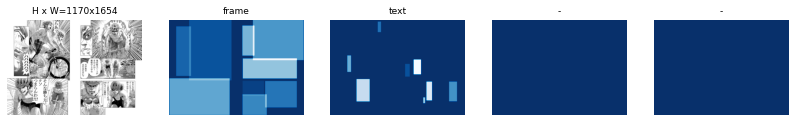

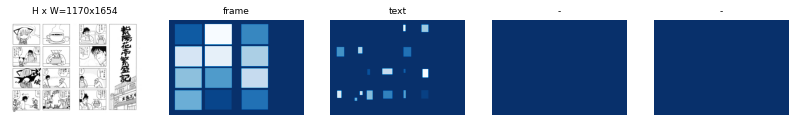

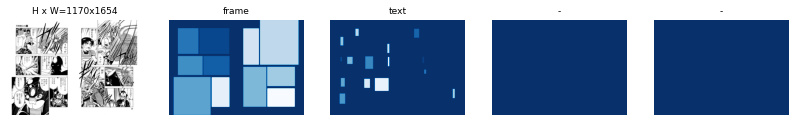

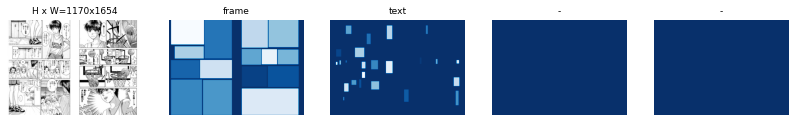

In [14]:
# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

## Training

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [16]:
# train all layers
model.train(train_set, test_set,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers="all")


Starting at epoch 0. LR=0.001

Checkpoint Path: model\manga20220205T1752\mask_rcnn_manga_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm

E:\Anaconda\envs\Project-Fugu-Manga-Translator\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
E:\Anaconda\envs\Project-Fugu-Manga-Translator\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
E:\Anaconda\envs\Project-Fugu-Manga-Translator\lib\site-packages\tensorflow\python\framework\indexed_slices.py

1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 1.0000 - loss: 3.0291 - rpn_class_loss: 0.3913 - rpn_bbox_loss: 1.0709 - mrcnn_class_loss: 0.5165 - mrcnn_bbox_loss: 0.5821 - mrcnn_mask_loss: 0.4683

E:\Anaconda\envs\Project-Fugu-Manga-Translator\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1000/1000 [==============================] - 1893s 2s/step - batch: 499.5000 - size: 1.0000 - loss: 3.0291 - rpn_class_loss: 0.3913 - rpn_bbox_loss: 1.0709 - mrcnn_class_loss: 0.5165 - mrcnn_bbox_loss: 0.5821 - mrcnn_mask_loss: 0.4683 - val_loss: 2.3494 - val_rpn_class_loss: 0.2777 - val_rpn_bbox_loss: 0.8041 - val_mrcnn_class_loss: 0.4393 - val_mrcnn_bbox_loss: 0.4186 - val_mrcnn_mask_loss: 0.4097


In [23]:
class InferenceConfig(MangaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  model\manga20220205T1752\mask_rcnn_manga_0001.h5
Re-starting from epoch 1


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1654.00000  float64
gt_class_id              shape: (22,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (22, 4)               min:    0.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 22)      min:    0.00000  max:    2.00000  uint8


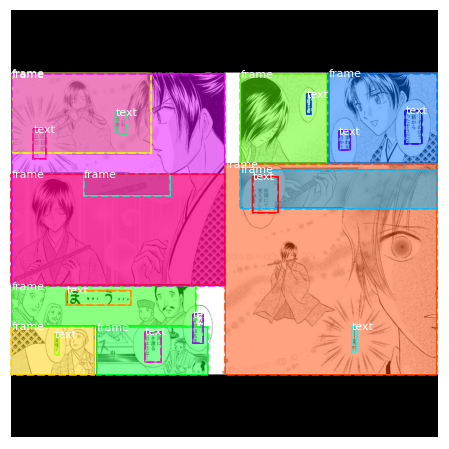

In [24]:
import random
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, inference_config, image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            train_set.class_names, figsize=(8, 8))